In [1]:
using Plots
using SpecialFunctions
using LinearAlgebra
using FFTW
using GPUArrays
using BenchmarkTools
using Optim
using Statistics
using Test
using ProgressMeter
using HDF5
using Printf
using Flux
using ParallelStencil
@init_parallel_stencil(CUDA, Float64, 3)
using StatsBase
using DelimitedFiles
using LineSearches

In [3]:
Float= Float64;
Int= Int32;
xpu= gpu;

In [74]:
include("wavelets.jl");
include("Synthetics.jl");
include("utils_bp.jl");
include("backproject.jl");
include("utils_optim.jl");

In [5]:
v0= 8.000 # km/s Velocity around the source grid
d0= 10000.0; # km

In [6]:
# Time grid
nt = 800
dt= 0.5
fmax= 0.25/dt
tgrid = Float.(range(-200, stop=200, step= dt)); # time samples from -200, 200 seconds
nt= length(tgrid);

801

In [111]:
eq= "chl1";

# Different eqs would have different grids, depending on the extent of rupture
dx= 10; dy= 10; 
limx= 500; limy= 500; # km
dT= 0.5;
Tgrid = range(-50, 200, step= dT);

In [112]:

dobs, k= get_symae_data(eq);

cntr, θ, ϕ, travel_times, network, ids, nevids= obspy_data(eq, "/home/abhinav/workspace/Bp_eq_data_processed", "/mnt/data2/isha/unique_pwin33_traces/");
nr= length(θ);

θ, ϕ, travel_times, network, ids, nr, nevids, IDs= filter_nevids(eq, θ, ϕ, travel_times, network, ids, nr, nevids);
dobs= cpu(dobs)[:,IDs] |>xpu;

bins= range(-180, 180, step= 2);#.*π./180;

# cntr, θ, ϕ, travel_times, network, nr, IDs= get_unique_receivers_per_bin(cntr, θ, ϕ, travel_times, network, θ, bins, nr, 1);
# nevids= nevids[IDs];
# dobs= cpu(dobs)[:,IDs] |>xpu;

cntr, θ, ϕ, travel_times, nevids, nr, IDs= filter_arrays([8], cntr, θ, ϕ, travel_times, nevids, nr)
dobs= cpu(dobs)[:,IDs] |>xpu;

# cntr, θ, ϕ, travel_times, nevids, nr, IDs= get_unique_receivers(cntr, θ, ϕ, travel_times, nevids, nr)
# dobs= cpu(dobs)[:,IDs] |>xpu;

# rgrid
rx= zeros(nr);
ry= zeros(nr);
rz= zeros(nr);

for i in 1:nr rz[i], ry[i], rx[i]= d0.*to_zyx(θ[i], ϕ[i]) end

sizeof(f) = 16
(sizeof(dat), sizeof(dobs)) = (64, 16074468)


┌ Info: Loading the grid data for chl1 from the loaded dataset in the saved directory.
└ @ Main /home/abhinav/workspace/utils_bp.jl:27
┌ Info: Number of receivers reduced to 3710
└ @ Main /home/abhinav/workspace/utils_bp.jl:252
┌ Info: Number of receivers reduced to 112
└ @ Main /home/abhinav/workspace/utils_bp.jl:146


In [116]:
zgrid = Float.([0])
ygrid = Float.(range(-limy, stop=limy, step=dy))
xgrid = Float.(range(-limx, stop=limx, step=dx))
mgrid= [zgrid, ygrid, xgrid, Tgrid];
rgrid= [rz, ry, rx];
nz, ny, nx, nT= length.(mgrid)
Tshift= Int.(round.(Tgrid./dt))
shift= get_shifts(mgrid, rgrid, v0, d0);
ricker(t)= delta(t);

@show nz, ny, nx, nT, nt, nr;

(nz, ny, nx, nT, nt, nr) = (1, 101, 101, 501, 801, 112)


In [118]:
wavg= fill(Float(0.), nt, 1, 1, 1, 1, 1) |>xpu; # ricker
shiftg= fill(Int(0), 1, nr, nz, ny, nx, 1)|>xpu; # time shifts
Tshiftg= fill(Int(0), 1,1,1,1,1,nT)|>xpu; #time shits for temporal domain
@allowscalar copyto!(view(wavg, :, 1, 1, 1, 1, 1), path_wav.(tgrid))# ;FFTW.rfft(r));
@allowscalar copyto!(view(shiftg, 1 , :, :, :, :, 1), permutedims(shift, [4, 1, 2, 3]));
@allowscalar copyto!(view(Tshiftg, 1, 1, 1, 1, 1, :), Tshift);
delay= broadcast(+, shiftg, Tshiftg);
(lb, ub)= extrema(tgrid)./dt .- reverse(extrema(cpu(delay)));

exp_tgrid= Float.(dt.*(lb:ub));
wav0= Float.(ricker.(exp_tgrid)) |>xpu;
dg= zeros(Float, nt, nr) |>xpu;
img= zeros(Float, nz, ny, nx, nT) |>xpu;

mvec= zeros(Float, 1, 1, nz, ny, nx, nT) |>xpu;
dvec= zeros(Float, nt, nr, 1, 1, 1, nT) |>xpu;
g2= zeros(Float, nt, nr, nT) |>xpu;
grvec= zeros(Float, 1, 1, nz, ny, nx, nT) |>xpu;
ddvec= zeros(Float, nt, nr, 1, 1, 1, 1) |>xpu;

G!(d,m)= G_ps!(d, m, delay, nt, nr, nz, ny, nx, nT, wav0, mvec, dvec, Int(abs(lb)));
Gt!(grad, ∇d)= Gt_ps!(grad, ∇d, delay, nt, nr, nz, ny, nx, nT, wav0, g2, grvec, ddvec, Int(abs(lb)));

In [125]:
# # Synthetic test
# source_wav(t)= rick(0.05, t);

# izloc= 1; #fill(1, 40);
# ixloc= 31; #:70; 
# iyloc= 71; #fill(21, 40);
# iTloc= 101;# .+ collect(1:40);
# source!(dobs, mgrid, rgrid, v0, d0, source_wav, izloc, iyloc, ixloc, iTloc)

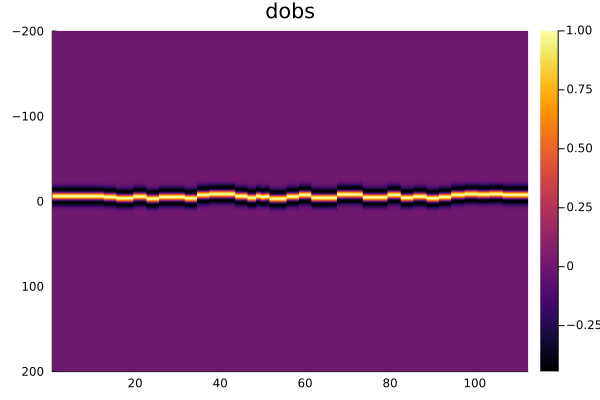

In [126]:
heatmap(1:nr, tgrid, cpu(dobs), yflip= true, title= "dobs")

In [96]:
λ= 0.001;
fill!(dg, 0.);
fill!(img, 0.);
algo= LBFGS(linesearch= BackTracking(order= 3))
backproject!(G!, Gt!, img, dobs, λ, mvec, dg, algo, 5);
# fname= "results/point_inv"
f= h5open(fname*".h5", "w")
write(f, eq, cpu(img));
close(f)

Iter     Function value   Gradient norm 
     0     1.494166e-02     6.242197e-04
 * time: 0.0007519721984863281
     1     5.143455e-03     2.564274e-04
 * time: 37.91922402381897
     2     3.901202e-03     1.561756e-04
 * time: 76.02659797668457
     3     2.125807e-03     9.018878e-05
 * time: 114.32886791229248
     4     1.776771e-03     1.021097e-04
 * time: 152.3402099609375
     5     1.329154e-03     9.316956e-05
 * time: 190.55048084259033


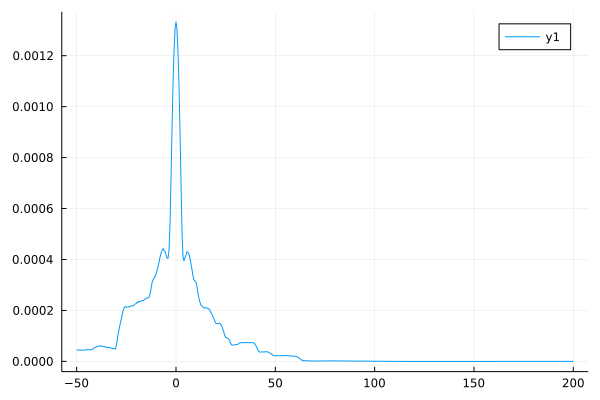

In [97]:
peak_amp= [maximum(cpu(img[:,:,:,iT])) for iT in 1:nT];
plot(Tgrid, peak_amp)
# savefig("source.png")

┌ Info: Saved animation to 
│   fn = /home/abhinav/workspace/tmp.gif
└ @ Plots /home/abhinav/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/abhinav/workspace/tmp.gif")
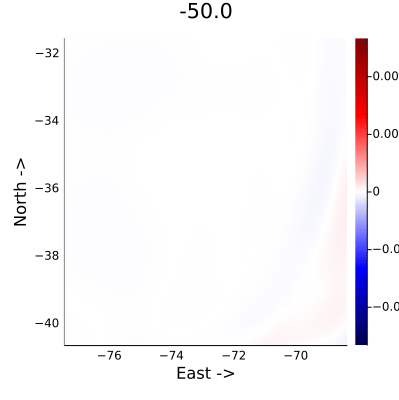

In [79]:
lim= maximum(extrema(cpu(img)))
anim= @animate for i in 1:nT
    heatmap(xgrid./111 .+cntr[2], ygrid./111 .+ cntr[1], real.(cpu(img)[1,:,:,i]), yflip= false, title= string(Tgrid[i]), 
        clims= (-lim, lim), c=:seismic,
        xlabel= "East ->", ylabel= "North ->", size= (400,400)
    )
end
# images come out right with yflip=true, implies algorithm is working fine. We need yflip= false to get north pointing upwards (ygrid= -limy: dy: limy)

gif(anim)